# Análise de melanoma

Esse jupyter visa em demonstrar uma solução de análise de imagens para predição de cancer do tipo melanoma. Foi utilizado a base do kaggle https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data

Nesse trabalho será apresentado o método de treinamento, os resultados com as variações e o código representa o melhor modelo de cada abordagem. Foi feito o treinamento utilizando Tensorflow + Keras.

# Setup

In [1]:
!pip install tensorflow
!pip install keras
!pip install tensorflow-datasets

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-08-06 09:21:18.969983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 09:21:19.342867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754482879.487402   97997 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754482879.526565   97997 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754482879.840011   97997 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Carregamento e tratamento do dataset

Foi escolhido o tamanho de 224x224 devido ao tamanho original das imagens não ser grande, por se tratarem de imagens próximas da pele das pessoas.

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data generators with resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and resize images automatically
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'  # or 'rgb' for color images
)

test_generator = test_datagen.flow_from_directory(
    './test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


[0. 1.]


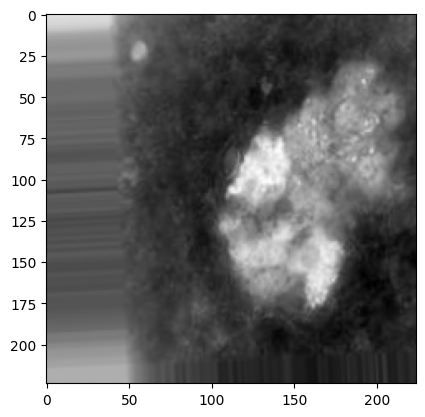

In [22]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

plt.imshow(train_images[3], cmap=plt.cm.binary)
print(train_labels[3])

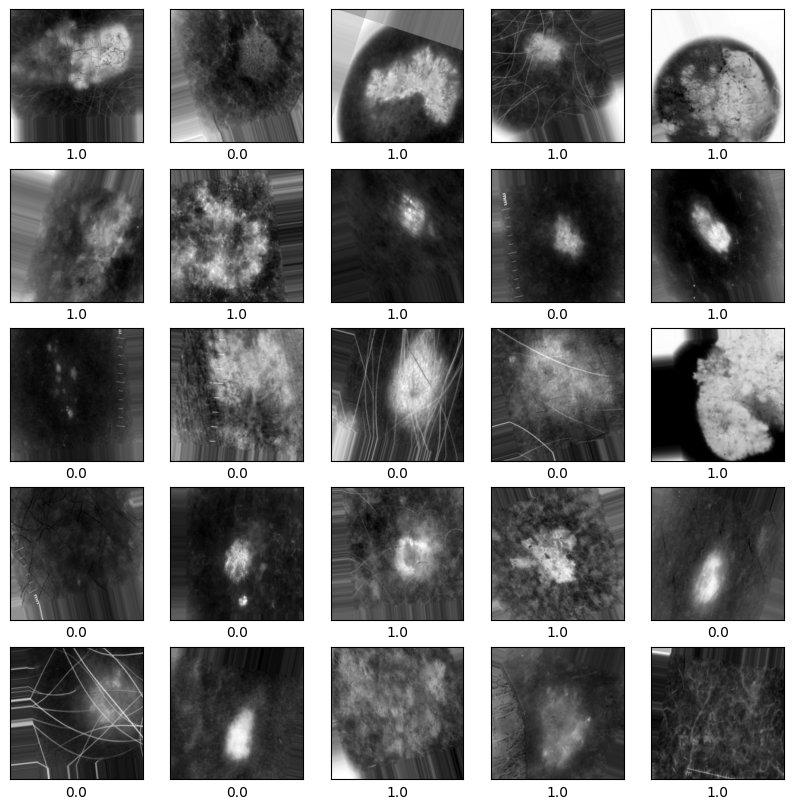

In [5]:
class_names = [[1, 0], [0, 1]]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(train_labels[i][1])
plt.show()

# Criando a CNN utilizando Keras + Tensorflow

Vamos selecionar e criar as camadas de redes neurais do modelo. Foi utilizada duas convoluções, a primeira de 32 bits, com um kernel de 3x3 e após isso uma com 64 features, ambos utilizando a ativação relu.

Foram escolhidos esses parametros devido a performance de treinamento e também por não ser imagens tão grandes.

Os resultados e código abaixo, representam o melhor resultado obtido de treinamento. No tópico "Variações testadas" irei abordar as variações testadas e seus resultados.

In [2]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,1)))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-04 00:32:44.355658: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (100)


<Sequential name=sequential, built=True>

Nessa etapa, iremos compilar o modelo e treinar o mesmo. Escolhemos as métricas de f1 score que englobam o recall, falso negativos e falso positivos.

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
        'accuracy',
        metrics.F1Score(name='f1_score'),
        metrics.FalseNegatives(name='false_negatives'),
        metrics.FalsePositives(name='false_positives')
    ])

history = model.fit(train_generator, epochs=300, validation_data=test_generator)

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 171s 454ms/step - accuracy: 0.6471 - f1_score: 0.6330 - false_negatives: 1986.3834 - false_positives: 1986.3834 - loss: 0.8085 - val_accuracy: 0.5855 - val_f1_score: 0.5187 - val_false_negatives: 829.0000 - val_false_positives: 829.0000 - val_loss: 0.6488
Epoch 2/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 149s 401ms/step - accuracy: 0.7001 - f1_score: 0.6846 - false_negatives: 1776.6381 - false_positives: 1776.6381 - loss: 0.5551 - val_accuracy: 0.6290 - val_f1_score: 0.6090 - val_false_negatives: 742.0000 - val_false_positives: 742.0000 - val_loss: 0.6192
Epoch 3/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 145s 388ms/step - accuracy: 0.7089 - f1_score: 0.7022 - false_negatives: 1706.0161 - false_positives: 1706.0161 - loss: 0.5344 - val_accuracy: 0.6795 - val_f1_score: 0.6526 - val_false_negatives: 641.0000 - val_false_positives: 641.0000 - val_loss: 0.5024
Epoch 4/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 146s 393ms/step - accuracy: 0.7572 - f1_score: 0.7535 - false_negati

In [16]:
# Função para extrair as labels do generator

def extract_labels_from_generator(generator):
    # Manual approach
    test_images = []
    test_labels = []

    # Reset generator
    generator.reset()

    # Collect all data
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        test_images.append(batch_images)
        test_labels.append(batch_labels)

    # Convert to arrays
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    print(f"Collected {len(test_images)} test images")
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels.shape}")

    return test_images, test_labels

In [17]:
test_images, test_labels = extract_labels_from_generator(test_generator)

test_loss, test_acc, f1_score, false_negatives, false_positives = model.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc}')
print(f'Test F1 score: {f1_score}')
print(f'Test False Negatives: {false_negatives}')
print(f'Test False Positives: {false_positives}')

Collected 2000 test images
Test images shape: (2000, 224, 224, 1)
Test labels shape: (2000, 2)


ValueError: You must call `compile()` before using the model.

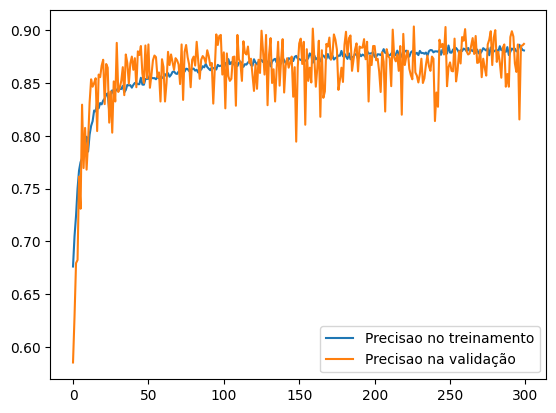

In [14]:
plt.plot(history.history['accuracy'], label='Precisao no treinamento')
plt.plot(history.history['val_accuracy'], label='Precisao na validação')
plt.legend()

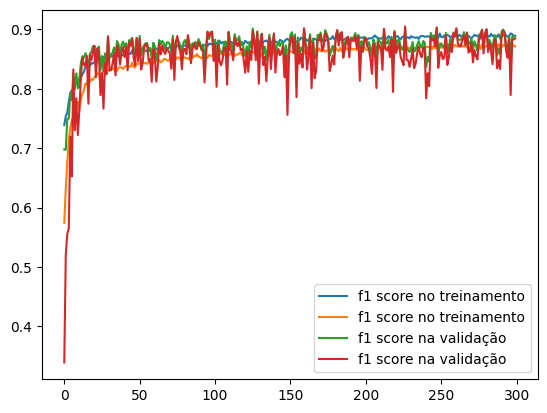

In [15]:
plt.plot(history.history['f1_score'], label='f1 score no treinamento')
plt.plot(history.history['val_f1_score'], label='f1 score na validação')
plt.legend()

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step


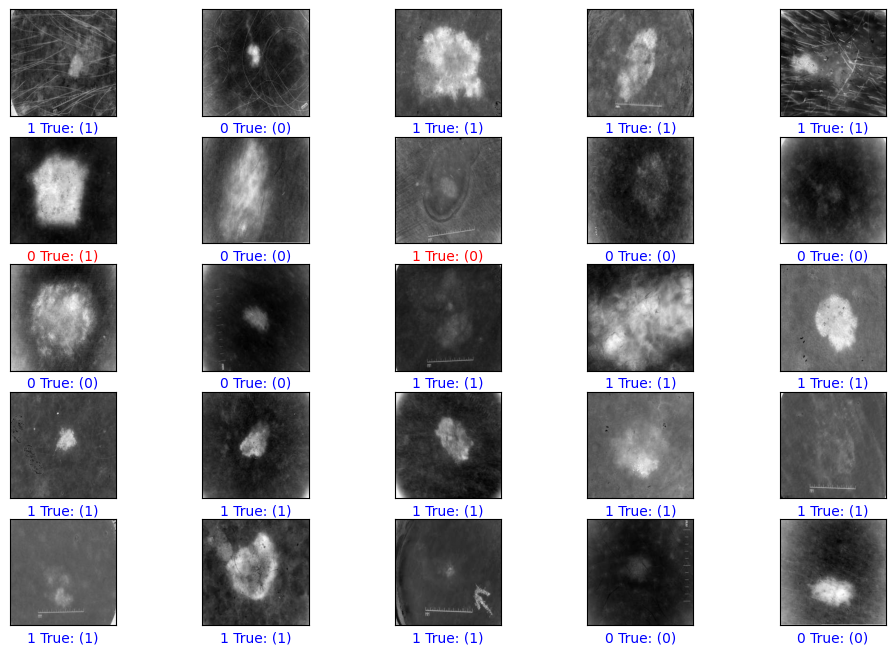

In [16]:
predictions = model.predict(test_images)

plt.figure(figsize=(12,8))

for i in range(25):
  plt.subplot(5, 5, i+1)

  plt.xticks([])
  plt.yticks([])

  # plt.grid(False)

  plt.imshow(test_images[i], cmap=plt.cm.binary)

  predict_label = np.argmax(predictions[i])

  true_label = np.argmax(test_labels[i])

  if predict_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f'{predict_label} True: ({true_label})', color=color)

plt.show()
#

## Modelo com 128 features

Vamos treinar o modelo agora com 128 features

In [10]:
model_128_features = models.Sequential()

model_128_features.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=(224,224,1)))

model_128_features.add(layers.MaxPooling2D((2,2)))

model_128_features.add(layers.Conv2D(128, (3,3), activation='relu'))

model_128_features.add(layers.MaxPooling2D((2,2)))

model_128_features.add(layers.Flatten())

model_128_features.add(layers.Dense(128, activation='relu'))

model_128_features.add(layers.Dense(2, activation='softmax'))

model_128_features

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_1, built=True>

In [14]:
model_128_features.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
        'accuracy',
        metrics.F1Score(name='f1_score'),
        metrics.FalseNegatives(name='false_negatives'),
        metrics.FalsePositives(name='false_positives')
    ])

history_128_features = model_128_features.fit(train_generator, epochs=100, validation_data=test_generator)

Epoch 1/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 238s/step - accuracy: 0.6741 - f1_score: 0.6394 - false_negatives: 1951.2178 - false_positives: 1951.2178 - loss: 0.6035  

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


372/372 ━━━━━━━━━━━━━━━━━━━━ 88352s 238s/step - accuracy: 0.6741 - f1_score: 0.6394 - false_negatives: 1956.2627 - false_positives: 1956.2627 - loss: 0.6035 - val_accuracy: 0.6065 - val_f1_score: 0.5790 - val_false_negatives: 787.0000 - val_false_positives: 787.0000 - val_loss: 0.6205
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6995 - f1_score: 0.6927 - false_negatives: 1773.8901 - false_positives: 1773.8901 - loss: 0.5353 - val_accuracy: 0.6125 - val_f1_score: 0.5760 - val_false_negatives: 775.0000 - val_false_positives: 775.0000 - val_loss: 0.6506
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.7255 - f1_score: 0.7203 - false_negatives: 1598.5469 - false_positives: 1598.5469 - loss: 0.5029 - val_accuracy: 0.7635 - val_f1_score: 0.7623 - val_false_negatives: 473.0000 - val_false_positives: 473.0000 - val_loss: 0.4500
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7532 - f1_score: 0.7495 - false_negatives: 1483.8070 - fal

In [18]:
test_images, test_labels = extract_labels_from_generator(test_generator)

test_loss, test_acc, f1_score, false_negatives, false_positives = model_128_features.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc}')
print(f'Test F1 score: {f1_score}')
print(f'Test False Negatives: {false_negatives}')
print(f'Test False Positives: {false_positives}')

Collected 2000 test images
Test images shape: (2000, 224, 224, 1)
Test labels shape: (2000, 2)
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.8524 - f1_score: 0.8519 - false_negatives: 160.3750 - false_positives: 160.3750 - loss: 0.3247
Test accuracy: 0.8489999771118164
Test F1 score: [0.8605724 0.8353326]
Test False Negatives: 302.0
Test False Positives: 302.0


Abaixo temos uma função para extrair as labels dos generators para podermos validar o resultado do modelo

Vamos realizar o predict para exibir o resultado das predições do model.

# Utilizando o modelo DenseNet121

Vamos utilizar esse modelo, devido a estudos que analisaram o seu desempenho para detecção de problemas de pele. Como estamos criando um modelo para a detecção de melanoma, esse modelo pré treinado pode funcionar bem.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
LEARNING_RATE = 0.001


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Carregar dados
train_generator_rgb = train_datagen.flow_from_directory(
    './train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'  # Mudando para RGB para usar o modelo pré-treinado
)

test_generator_rgb = test_datagen.flow_from_directory(
    './test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
def create_model_phase1():
    """Cria o modelo para a primeira fase do fine-tuning"""
    
    # Carregar modelo base pré-treinado
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Congelar todas as camadas do modelo base
    base_model.trainable = False
    
    # Criar modelo completo
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    
    return model

In [9]:
def create_model_phase2(base_model_weights):
    """Cria o modelo para a segunda fase do fine-tuning"""
    
    # Carregar modelo base
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Carregar pesos treinados da fase 1
    model_phase2 = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    
    # Carregar pesos da fase 1
    model_phase2.load_weights(base_model_weights)
    
    # Descongelar as últimas camadas do modelo base
    # Descongelar os últimos 30 blocos (aproximadamente 1/3 das camadas)
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    # Verificar quantas camadas estão treináveis
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model_phase2.trainable_weights])
    non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_phase2.non_trainable_weights])
    
    print(f"Parâmetros treináveis: {trainable_params:,}")
    print(f"Parâmetros não treináveis: {non_trainable_params:,}")
    
    return model_phase2

In [10]:
model_phase1 = create_model_phase1()

model_phase1.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Callbacks para fase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_f1_score',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_model_phase1.h5',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max'
    )
]

# Treinar fase 1
print("=== FASE 1: Treinando apenas camadas de classificação ===")
history_phase1 = model_phase1.fit(
    train_generator_rgb,
    epochs=50,
    validation_data=test_generator_rgb,
    callbacks=callbacks_phase1,
    verbose=1
)

2025-08-06 09:22:29.621523: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (100)


=== FASE 1: Treinando apenas camadas de classificação ===


/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7891 - f1_score: 0.7883 - loss: 0.5328

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:258: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87199605 0.86690456]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.7892 - f1_score: 0.7884 - loss: 0.5326 - val_accuracy: 0.8695 - val_f1_score: 0.8695 - val_loss: 0.3054 - learning_rate: 0.0010
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8469 - f1_score: 0.8461 - loss: 0.3483

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
model_phase2 = create_model_phase2('best_model_phase1.h5')

# Compilar com learning rate menor para fine-tuning
model_phase2.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE * 0.1),  # Learning rate menor
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Callbacks para fase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_f1_score',
        patience=15,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-8
    ),
    ModelCheckpoint(
        'best_model_final.h5',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max'
    )
]

# Treinar fase 2
print("=== FASE 2: Fine-tuning das camadas do modelo base ===")
history_phase2 = model_phase2.fit(
    train_generator_rgb,
    epochs=100,
    validation_data=test_generator_rgb,
    callbacks=callbacks_phase2,
    verbose=1
)

In [ ]:
def evaluate_model(model, test_generator):
    """Avalia o modelo final"""
    
    # Extrair dados de teste
    test_images, test_labels = extract_labels_from_generator(test_generator)
    
    # Avaliar modelo
    test_loss, test_acc, f1_score = model.evaluate(test_images, test_labels, verbose=0)
    
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test F1 Score: {f1_score}')
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss, test_acc, f1_score

def plot_training_history(history_phase1, history_phase2):
    """Plota o histórico de treinamento das duas fases"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Fase 1
    axes[0, 0].plot(history_phase1.history['accuracy'], label='Train')
    axes[0, 0].plot(history_phase1.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Fase 1 - Accuracy')
    axes[0, 0].legend()
    
    axes[0, 1].plot(history_phase1.history['f1_score'], label='Train')
    axes[0, 1].plot(history_phase1.history['val_f1_score'], label='Validation')
    axes[0, 1].set_title('Fase 1 - F1 Score')
    axes[0, 1].legend()
    
    # Fase 2
    axes[1, 0].plot(history_phase2.history['accuracy'], label='Train')
    axes[1, 0].plot(history_phase2.history['val_accuracy'], label='Validation')
    axes[1, 0].set_title('Fase 2 - Accuracy')
    axes[1, 0].legend()
    
    axes[1, 1].plot(history_phase2.history['f1_score'], label='Train')
    axes[1, 1].plot(history_phase2.history['val_f1_score'], label='Validation')
    axes[1, 1].set_title('Fase 2 - F1 Score')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Avaliar modelo final
print("=== AVALIAÇÃO DO MODELO FINAL ===")
final_model = tf.keras.models.load_model('best_model_final.h5')
evaluate_model(final_model, test_generator_rgb)

# Plotar histórico de treinamento
plot_training_history(history_phase1, history_phase2)

## Variações testadas

Nessa sessão, o resultado e a explicação de cada variação testada.

### 20 Epochs - Imagens de 64x64 - 64 features

Utilizando o mesmo código, treinando com somente 20 epochs, houve um resultado de 78% de acurácia aproximadamente, e um f1 score de 80% para a classe 0 (benigno) e de 75% para classe 1 (malígno)

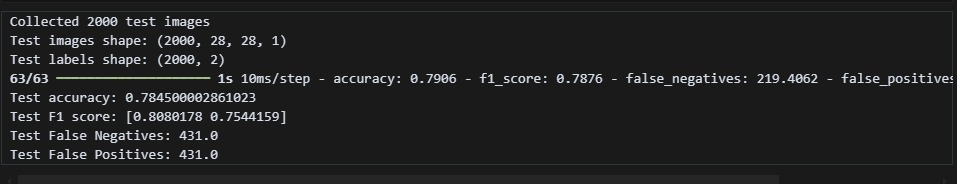

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image('20-epochs.jpeg'))

### 50 epochs - Imagens de 64x64 - 64 features

Utilizando o mesmo código, com 50 epochs, houve uma melhora considerável, principalmente na predição do caso da classe 1. Tivemos um aumento para 86% de acurácia, 86% de f1 score para a classe 0 e 85% para classe 1.

Foi visto que 20 epochs é um valor muito baixo para esse dataset. Onde houve uma melhora muito grande na acertividade do modelo e em sua confiabilidade.

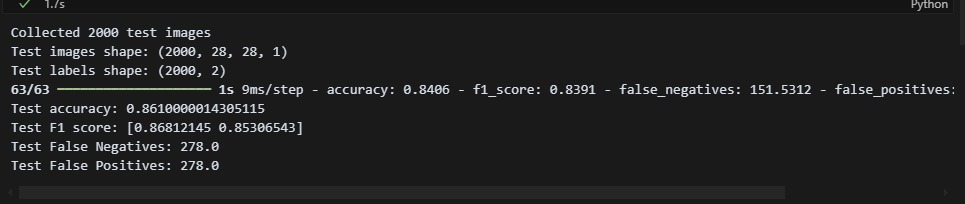

In [ ]:
# Display the image
display(Image('50-epochs.jpeg'))

### 100 epochs - Imagens de 224x224 - 64 features

Agora, aumentamos as epochs e o tamanho da imagem. Foi visto que ela estava bastante desfocada, provavelmente atrapalhando o desempenho do modelo

Com o aumento de detalhes da imagem, aumentei também o número de epochs para a melhorar o aprendizado do modelo.

Houve um pequeno aumento na acurácia, para 86,5%, e no f1 score aumento para 87% para a classe 0 e 85% para a classe 1.

Podemos dizer que o desempenho da variação com 100 epochs e 50, deram um resultado bem similar


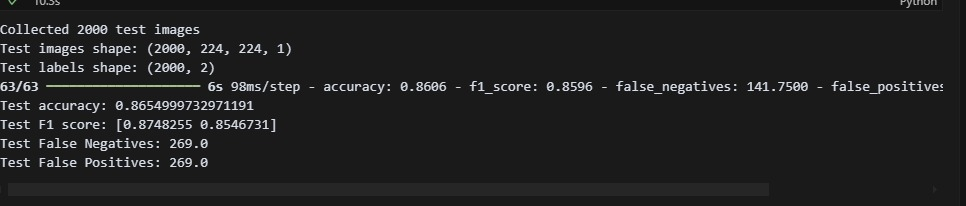

In [ ]:
# Display the image
display(Image('100-epochs.jpeg'))

## 300 epochs - Imagens de 224x224 - 64 features

Aumentamos o número de épocas, para 300. Aqui observamos uma melhora significativa, chegando em patamares próximos a 89% em todas as métricas.

Vemos também uma redução considerável nos falsos negativos e positivos.

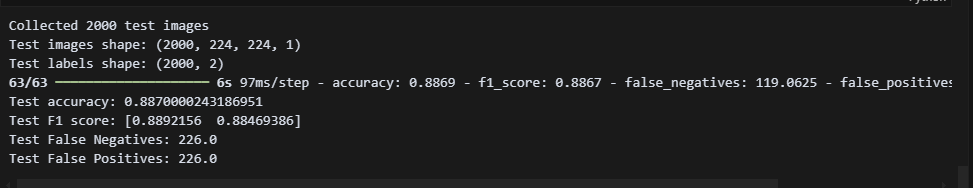

In [ ]:
# Display the image
display(Image('300-epochs-sem-dropout.png'))

## 100 epochs - 128 features

Aumentamos a camada de extração de features, para 128. Foi diminuido a quantidade de epochs para 100, devido ao tempo de treinamento.

No fim, tivemos um resultado inferior ao de 300 epochs com 64 features. Perdemos a acurácia e f1 score em 3%. Tendo um quantidade de falsos negativos e positivos maior

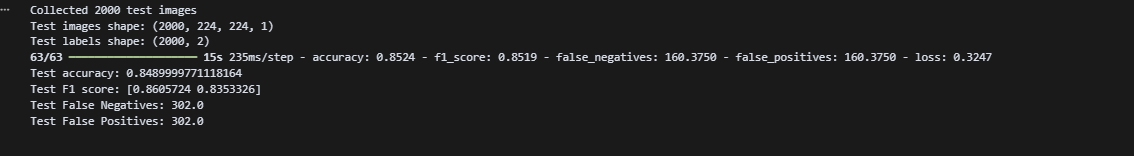

In [ ]:
# Display the image
display(Image('100-epochs-128.png'))